In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import random


import ast

import json
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix, traffic):
    with open(f"{META_FOLDER}/{traffic}.json") as f:
        meta_data = json.load(f)
    def translate_action(action):
        # TODO: add fix in evaluate script
        if action.startswith("["):
            action = action.replace("  ", " ").replace("[ ", "[").replace(" ", ", ").replace(",,", ",")
        action = ast.literal_eval(action)
        tf_ids = list(ast.literal_eval(df_single_episode.obs.to_list()[0]).keys())
        n_splits = len(action)
        if isinstance(action, list):
            if len(action) == 1:
                action_dict = {tf_ids[0]: action[0]}  # TODO: rename traffic signal in single traffic light scenario
            else:
                action_dict = {tf_ids[i]: a 
                              for i, a in enumerate(action)}
        
        green = []
        for tf_id, p in action_dict.items():
#             print(tf_id, p , meta_data[tf_id]["phases"])
            green_tf = f"{tf_id}:"
            green_tf += ", ".join(meta_data[tf_id]["phases"][str(p)]["lanes_green"])
            green.append(green_tf)
        return "; ".join(green)
    print("Loading", f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    df_single_episode["translated_action"]= df_single_episode['action'].apply(
        lambda x: translate_action(x)
    )
    n_splits = len(df_single_episode.translated_action.to_list()[0].split("; "))
    df_single_episode[[f"translated_action_tf_{i}"
                      for i in range(n_splits)]] = df_single_episode['translated_action'].str.split('; ', expand=True)
    
    
    # df_multiple_episodes = pd.read_csv(f'{EVAL_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    df_multiple_episodes = None
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    
    with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
        meta_data = json.load(f)
    
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():        
        phase_ids = observation_dict["current_phase_ids"]
        queue = observation_dict["queue"]
        waiting_times = []
        for waiting_time in observation_dict["waiting_times"]:
            if waiting_time:
                waiting_times.append(np.max(waiting_time))
            else:
                waiting_times.append(0)
        observation = np.array(phase_ids + queue + waiting_times, dtype=np.float32)
        # TODO: check if I can update the phase ids?
        # TODO: double check queue_der
        tf_meta_data = meta_data[tf_id]        
        
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if key in ["current_phase_ids", "queue", "waiting_times"]:
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        suffix = index
                        if key in ["queue", "waiting_times"]:
                            suffix = tf_meta_data["lanes"]["cleaned_incoming"][str(index)]
                        if key == "waiting_times":
                            if item:
                                item = np.max(item)
                            else:
                                item = 0
                        unnested_obs[f"{tf_id}_{key}_{suffix}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)

    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


In [3]:

import torch.nn.init as init


class ReluNetwork(nn.Module):
    def __init__(self, input_size, output_size, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )
        self.to(device)
        # self.apply(self.init_weights)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class MultiDiscreteReluNetwork(nn.Module):
    def __init__(self, input_size, action_sizes, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            # nn.Linear(256, n_actions),
        )
        # self.apply(self.init_weights)
        self.heads = nn.ModuleList(
            nn.Linear(256, int(size)) for size in action_sizes
        )
        self.to(device)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        items = self.linear_relu_stack(x)
        logits = [head(items) for head in self.heads]
        return logits

class QNetwork(nn.Module):
    def __init__(self, obs_size, action_size, device):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_size),
        )
        self.to(device)
        # This is required as otherwise it's possible that the random
        # initialization of the weights will cause the network to output
        # a higher Q value for a state/option pair for which we did not train
        # This because the rewards tend to be negative
        # self.apply(self.init_weights)


    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.constant_(m.weight, -10.0)  # Initialize weights to large negative values
            if m.bias is not None:
                init.constant_(m.bias, -10.0)  # Initialize biases to large negative values


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class TerminationFunctionNetwork(nn.Module):
    """This neural network predicts the probability of terminating an option.
    """
    def __init__(self, obs_size, n_options, device):
        super().__init__()  
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.Tanh(),
            # nn.Linear(256, 256),
            # nn.LeakyReLU(),
            nn.Linear(256, n_options),
        )
        self.to(device)
        self.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier initialization
            if m.bias is not None:
                init.constant_(m.bias, random.uniform(0, 1))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
EVAL_FOLDER = '../evaluations'
META_FOLDER = "../meta"
MODELS_FOLDER = "../models"
TRAFFIC = "3x3grid-3lanes2"
# MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_248400_steps"
# MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_testing_248400_steps"
MODEL = "option_critic_nn_curriculum_2_options_3x3grid-3lanes2_start_min_policy_length_4_weights_d3_w3_ls2_ola1_248400_steps"
MODEL += "_broken"
N_OPTIONS = 2

/tmp/ipykernel_11037/3354674213.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


Loading ../evaluations/option_critic_nn_curriculum_2_options_3x3grid-3lanes2_start_min_policy_length_4_weights_d3_w3_ls2_ola1_248400_steps_broken_3x3grid-3lanes2_1_episode.csv
Test Accuracy: 0.98


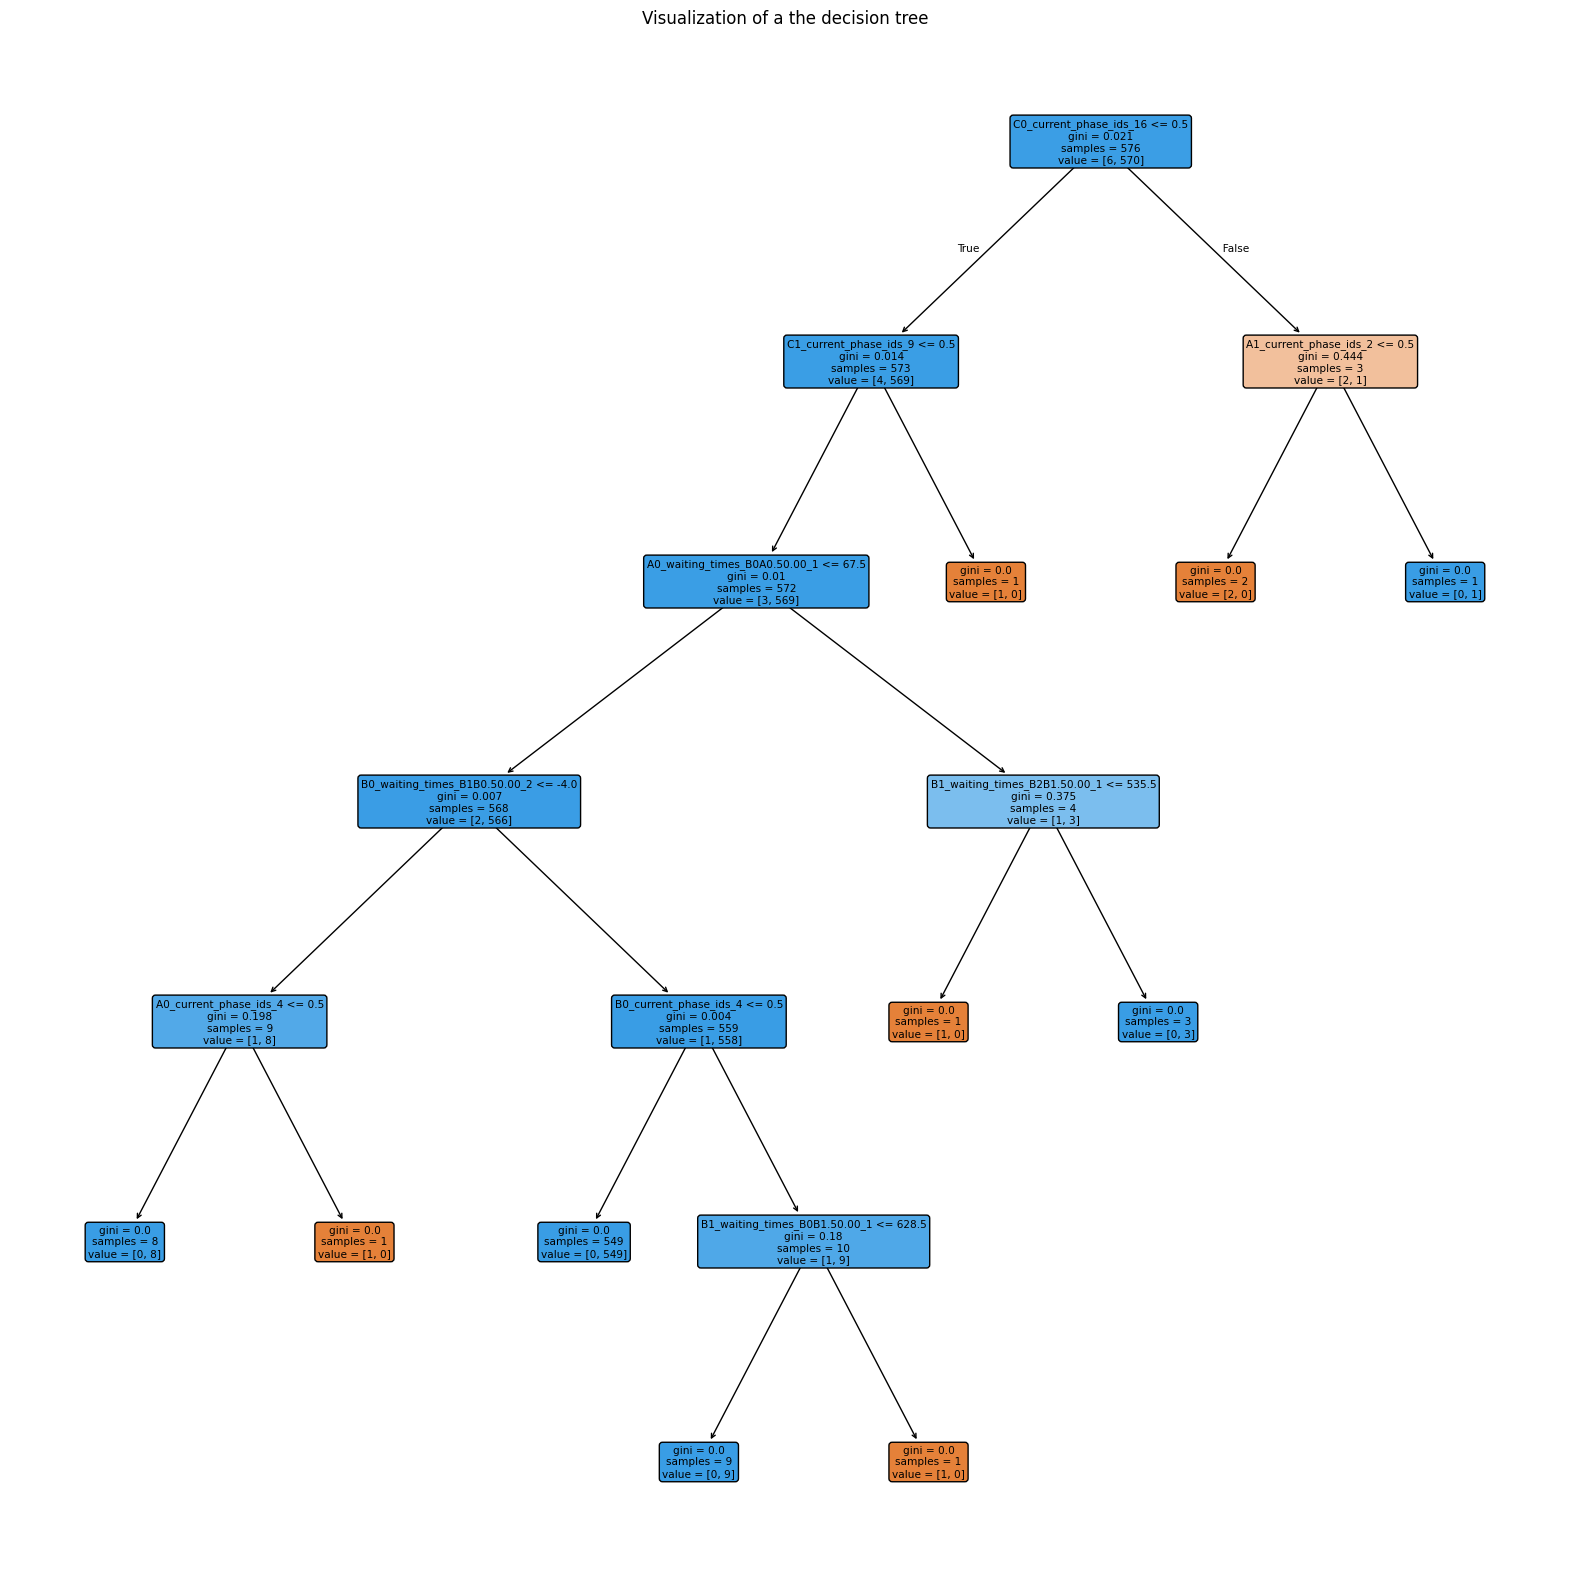

In [5]:
df_single_episode, _ = load_data(MODEL, TRAFFIC)

results = []
for index in range(df_single_episode.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    keys = [key for key in unnested_dict if "min_green" in key]
    for key in keys:
        _ = unnested_dict.pop(key)
    unnested_dict["should_terminate"] = df_single_episode.should_terminate.to_list()[index]
    results.append(unnested_dict)
df_actions = pd.DataFrame(results)

X = df_actions.loc[:, df_actions.columns != 'should_terminate'] # Select all columns except the option column
y = df_actions.loc[:, df_actions.columns == 'should_terminate']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Visualization of a the decision tree")
plt.show()

In [6]:
with open(f"{META_FOLDER}/{TRAFFIC}.json") as f:
    meta_data = json.load(f)

model_params = torch.load(
    f"{MODELS_FOLDER}/{MODEL.replace('_broken', '')}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")

termination_model.load_state_dict(termination_network_params)

q_model = QNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

q_model.load_state_dict(q_model_params)

option_policies = {}
for option in range(N_OPTIONS):
    option_policy_model_params = model_params[f'option_policy_{option}']
    heads = [key for key in list(option_policy_model_params.keys()) if key.startswith("heads") and key.endswith("weight")]
    option_policy_model = MultiDiscreteReluNetwork(input_size=list(option_policy_model_params.values())[0].shape[1],
                      action_sizes=[len(option_policy_model_params[head]) for head in heads],
                      device="cpu")
    option_policy_model.load_state_dict(option_policy_model_params)

    option_policies[option] = option_policy_model


/tmp/ipykernel_7680/2163389671.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


Loading ../evaluations/option_critic_nn_curriculum_2_options_3x3grid-3lanes2_start_min_policy_length_4_weights_d3_w3_ls2_ola1_248400_steps_broken_3x3grid-3lanes2_1_episode.csv
Test Accuracy: 0.99


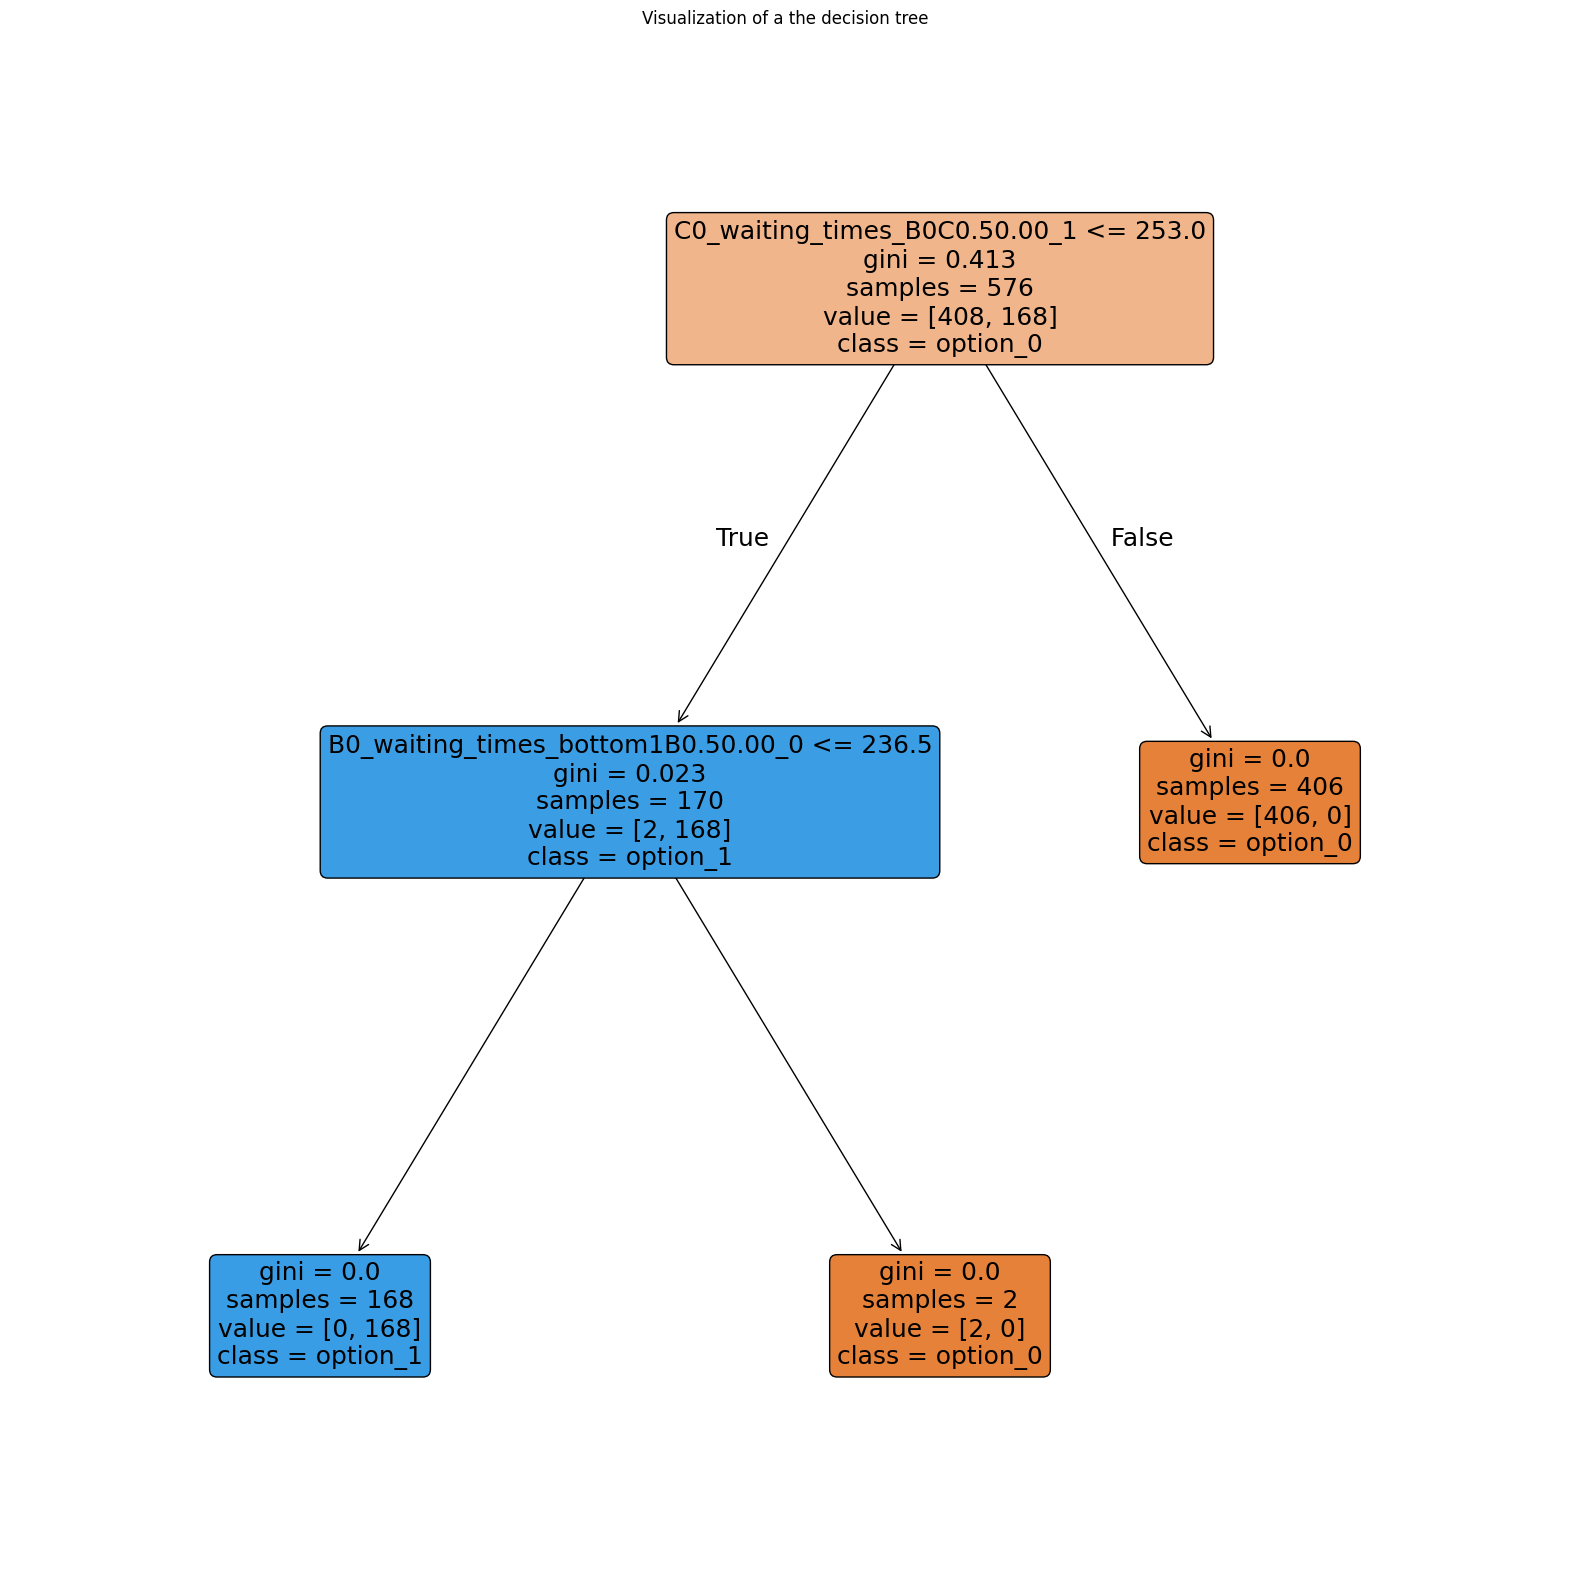

In [7]:
df_single_episode, _ = load_data(MODEL, TRAFFIC)

results = []
for index in range(df_single_episode.shape[0]):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    keys = [key for key in unnested_dict if "min_green" in key]
    for key in keys:
        _ = unnested_dict.pop(key)
    option_values = q_model(prep_state(obs))[0]
    unnested_dict["predicted_option"] = torch.argmax(option_values).item()
    results.append(unnested_dict)
df_actions = pd.DataFrame(results)

X = df_actions.loc[:, df_actions.columns != 'predicted_option'] # Select all columns except the option column
y = df_actions.loc[:, df_actions.columns == 'predicted_option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, class_names=['option_0', 'option_1'])
plt.title("Visualization of a the decision tree")
plt.show()